# Kung Fu Pandas Report
-------------------
### Authors:
Piotr Balewski \
Adam Dobosz \
Wiktor Kamzela \
Michał Redmer 

## Introduction
As a team, our goal will be to implement methods learned during Data Mining course in order to obtain the most accurate regression model, predicting the price of a car.
Multiple preprocessing techniques will be utilized in the following experiments; feature normalization, standardization, selection and extraction. These techniques are crucial for transforming raw data into a format suitable for training machine learning models.

## Description of the dataset

The dataset under consideration, ["90,000+ Cars Data From 1970 to 2024"](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024), offers a comprehensive collection of car-related information spanning several decades. With over 90,000 entries and 10 columns, this dataset provides a rich source of data for our analysis. The original dataset comprising 100,000 scraped used car listings was collected and cleaned by Aditya.
Due to its recent availability of only 2 months, hopefully we will be able to discover plenty of new, unexpected and insightful relationships.


## Description of the input features

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('CarsData.csv')
target = data.price
input_features = data.drop('price', axis=1)

Input comprise 9 features:
1. model
2. year
3. transmissions
4. mileage,
5. fuelType,
6. tax,
7. mpg,
8. engineSize,
9. Manufacturer, 

5 of them being numerical and 4 categorical.

## Exploratory Analysis of the input features

Let's take a glance at the data:

In [19]:
input_features.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,I10,2017,Manual,11630,Petrol,145,60.1,1.0,hyundi
1,Polo,2017,Manual,9200,Petrol,145,58.9,1.0,volkswagen
2,2 Series,2019,Semi-Auto,1614,Diesel,145,49.6,2.0,BMW
3,Yeti Outdoor,2017,Manual,30960,Diesel,150,62.8,2.0,skoda
4,Fiesta,2017,Manual,19353,Petrol,125,54.3,1.2,ford


Now, we will inspect each column for missing values and incoherent datatypes.

In [20]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97712 entries, 0 to 97711
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         97712 non-null  object 
 1   year          97712 non-null  int64  
 2   transmission  97712 non-null  object 
 3   mileage       97712 non-null  int64  
 4   fuelType      97712 non-null  object 
 5   tax           97712 non-null  int64  
 6   mpg           97712 non-null  float64
 7   engineSize    97712 non-null  float64
 8   Manufacturer  97712 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 6.7+ MB


Fortunately, there are no missing values in our dataset. Furthermore, we can see the number of entries (97712) and the number of input features (9). Additionally, we can now divide our features into numerical and categorical.

In [27]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
cat_cols = ['model', 'transmission', 'fuelType',  'Manufacturer']

Now we will explore the distributions of numerical data.

/home/adam/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/adam/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/adam/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/adam/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

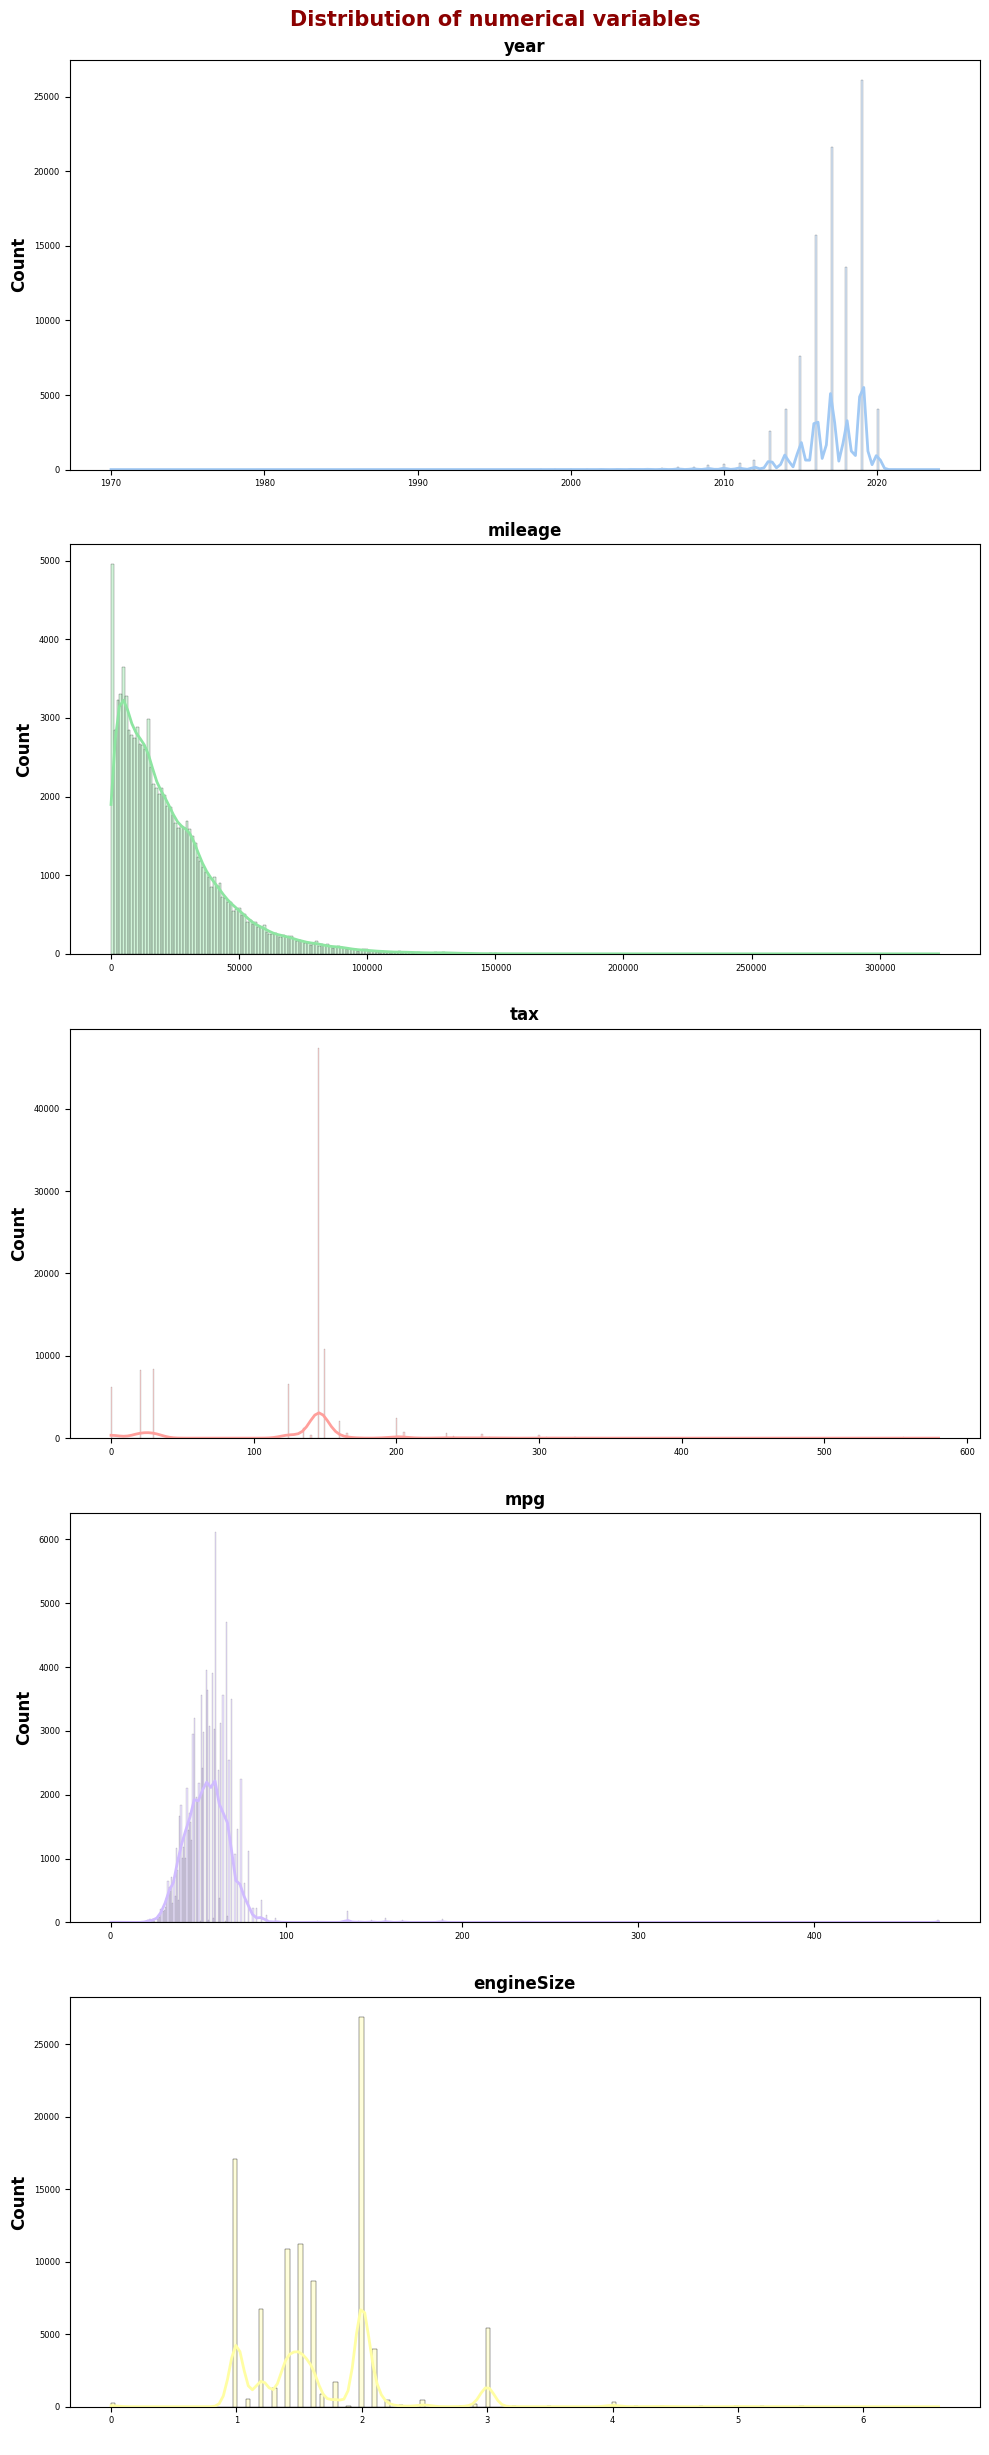

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(10, 25))
axes = axes.flat # flatten the axis to iterate over them

for i, col in enumerate(num_cols):
    sns.histplot(data=input_features,
        x=col,
        stat='count',
        kde=True, # smoothen the histogram
        color=sns.color_palette('pastel6')[i],
        line_kws={'linewidth': 2},
        alpha=0.4,
        ax=axes[i])

    axes[i].set_xlabel(" ")
    axes[i].set_ylabel("Count", fontsize=12, fontweight='bold', color='black')
    axes[i].set_title(col, fontsize=12, fontweight='bold', color='black')
    axes[i].tick_params(labelsize=6)

fig.suptitle('Distribution of numerical variables', fontsize=15, fontweight='bold', color='darkred')
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.show()

Great. Let's take a look at the distribution of categorical variables.

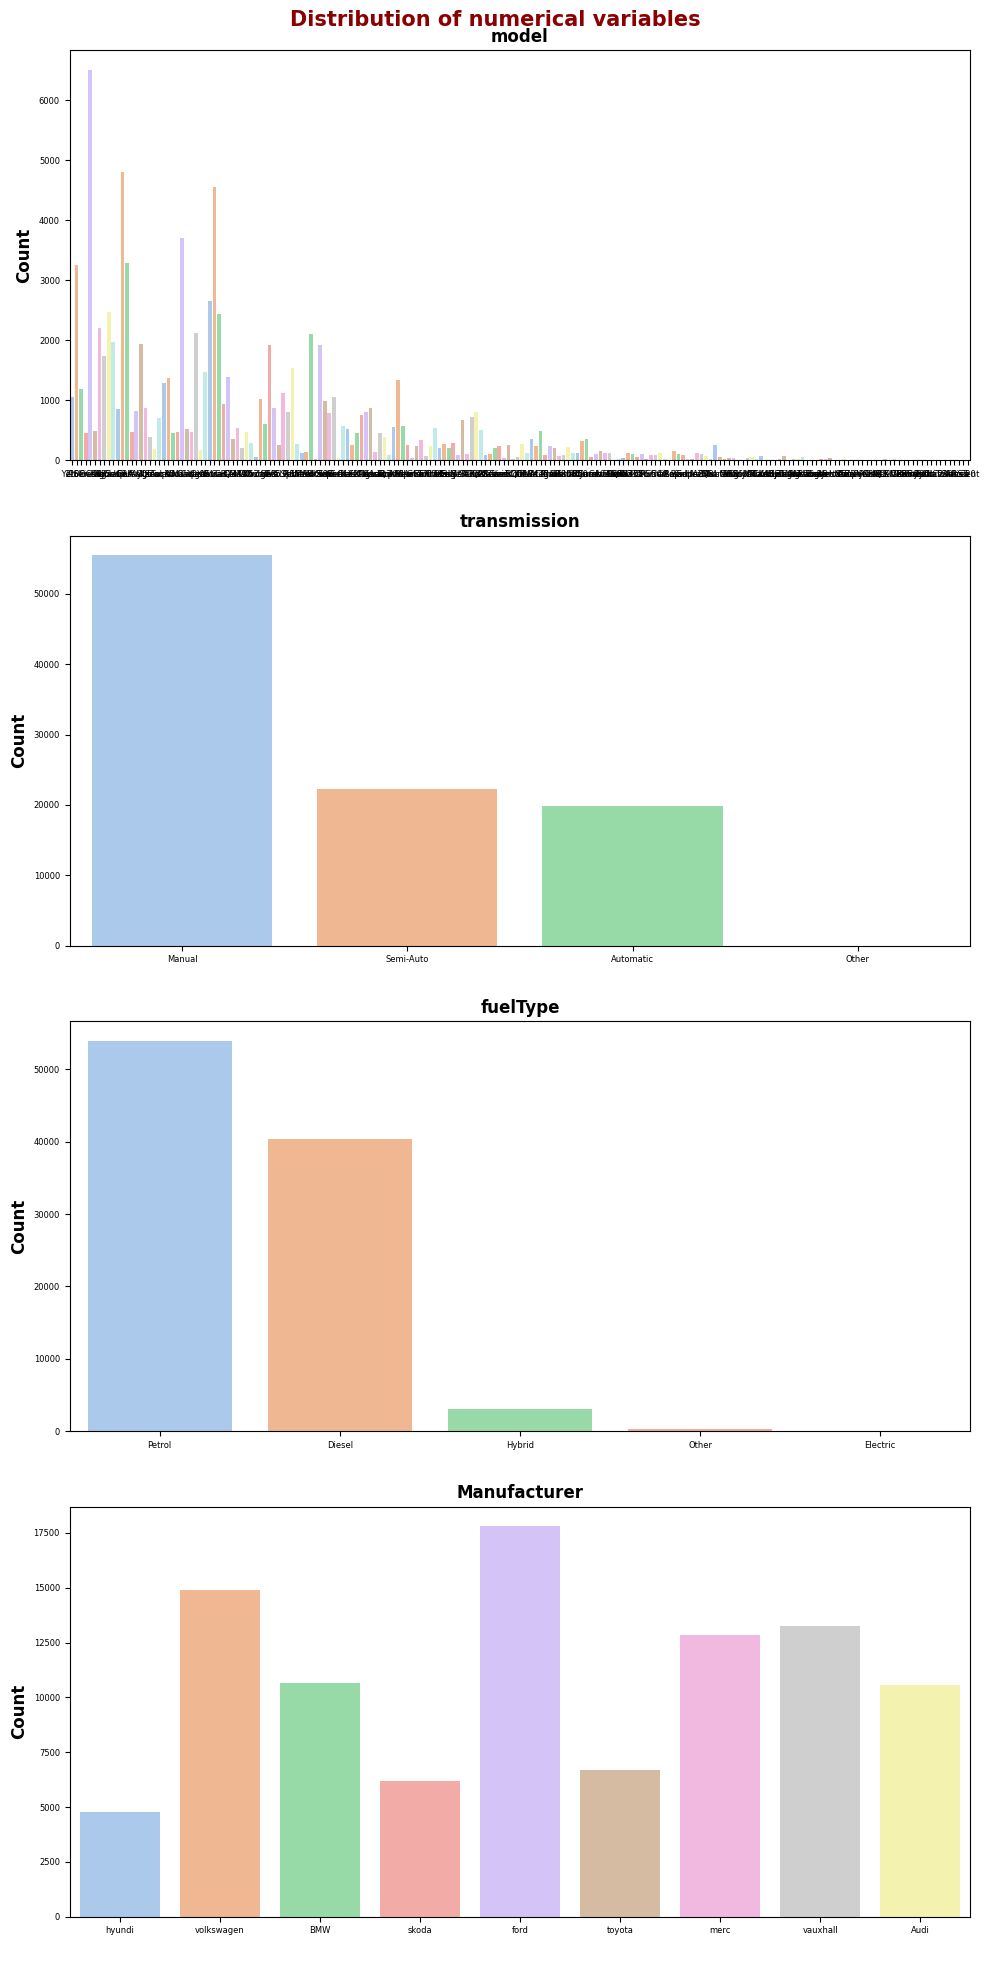

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.flat

for i, col in enumerate(cat_cols):
    # add countplot for each categorical column
    sns.countplot(data=input_features, x=col, palette='pastel', ax=axes[i])
    axes[i].set_xlabel(" ")
    axes[i].set_ylabel("Count", fontsize=12, fontweight='bold', color='black')
    axes[i].set_title(col, fontsize=12, fontweight='bold', color='black')
    axes[i].tick_params(labelsize=6)

fig.suptitle('Distribution of numerical variables', fontsize=15, fontweight='bold', color='darkred')
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.show()

As we can see, there is only a relatively small variety of categories in each column, except for the model. We will need to figure out a way to make it more convienient, such that it is easier to interpret and won't overfit the model.

In [33]:
print(data.model.nunique()) # number of unique values in model column
# print only values of model column that constitute over 1% of the data
models_over_1percent = data.model.value_counts(normalize=True)[data.model.value_counts(normalize=True) > 0.01]
print(len(models_over_1percent))
# sum of all values that are over 1%
print(models_over_1percent.sum())

196
29
0.6588852955624692


That's interesting, isn't it? 15% of all models contribute to almost 66% of the whole dataset! Let's find the most informative 

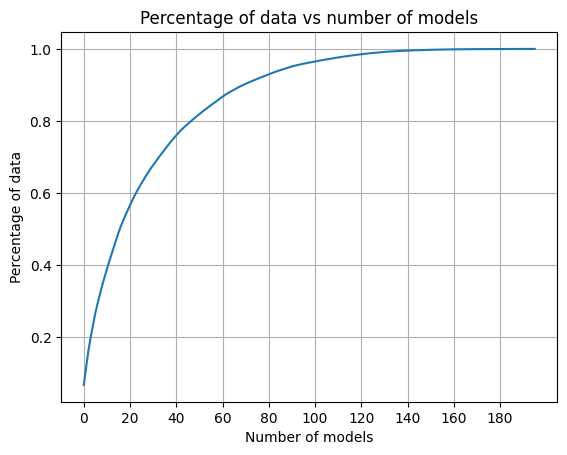

In [46]:
# plot number of models vs their count
data_percent_vs_num_of_models = []
for i in range(len(data.model.value_counts())):
    data_percent_vs_num_of_models.append(data.model.value_counts(normalize=True).iloc[:i+1].sum())
plt.plot([i for i in range(len(data.model.value_counts()))], data_percent_vs_num_of_models)
plt.grid()
plt.xticks([i for i in range(0, len(data.model.value_counts()), 20)])
plt.xlabel('Number of models')
plt.ylabel('Percentage of data')
plt.title('Percentage of data vs number of models')
plt.show()

As we can see, the elbow is not obvious, however we can select a desired threshold value easily.

## Preprocessing techniques used in the assignment
### Description
### Motivation

## Description of the output features 

## Exploratory analysis of the output features

Conclusions

In [5]:
print(data.head())

           model  year  price transmission  ...  tax   mpg  engineSize  Manufacturer
0            I10  2017   7495       Manual  ...  145  60.1         1.0        hyundi
1           Polo  2017  10989       Manual  ...  145  58.9         1.0    volkswagen
2       2 Series  2019  27990    Semi-Auto  ...  145  49.6         2.0           BMW
3   Yeti Outdoor  2017  12495       Manual  ...  150  62.8         2.0         skoda
4         Fiesta  2017   7999       Manual  ...  125  54.3         1.2          ford

[5 rows x 10 columns]


In [10]:
print(len(models_over_1percent)/len(data.model.unique()))

0.14795918367346939
